In [17]:
# Take the output from our modulation notebook and apply some channel effects to it
# This is a simple model of a channel with multipath and noise

# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Import the modulation notebook
from IPython.utils import io
with io.capture_output() as captured:
    %run 'tetra_modulation.ipynb'

In [18]:
# Add some noise
from commpy.channels import awgn
SNR = 25
samples = awgn(samples, SNR)

(0.0, 640.0)

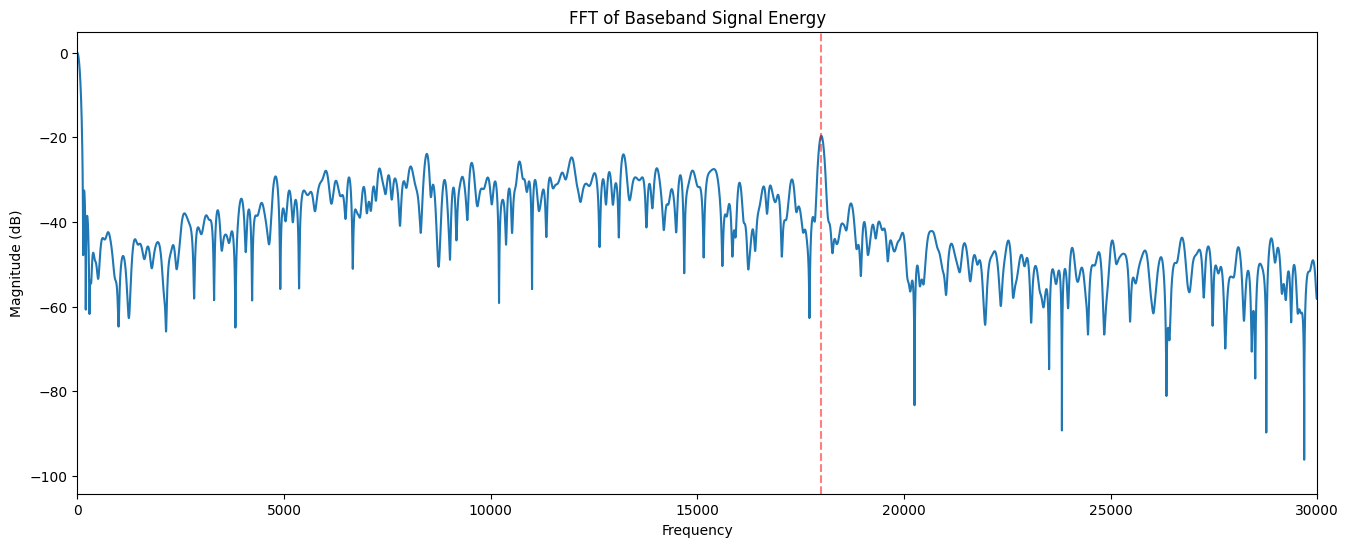

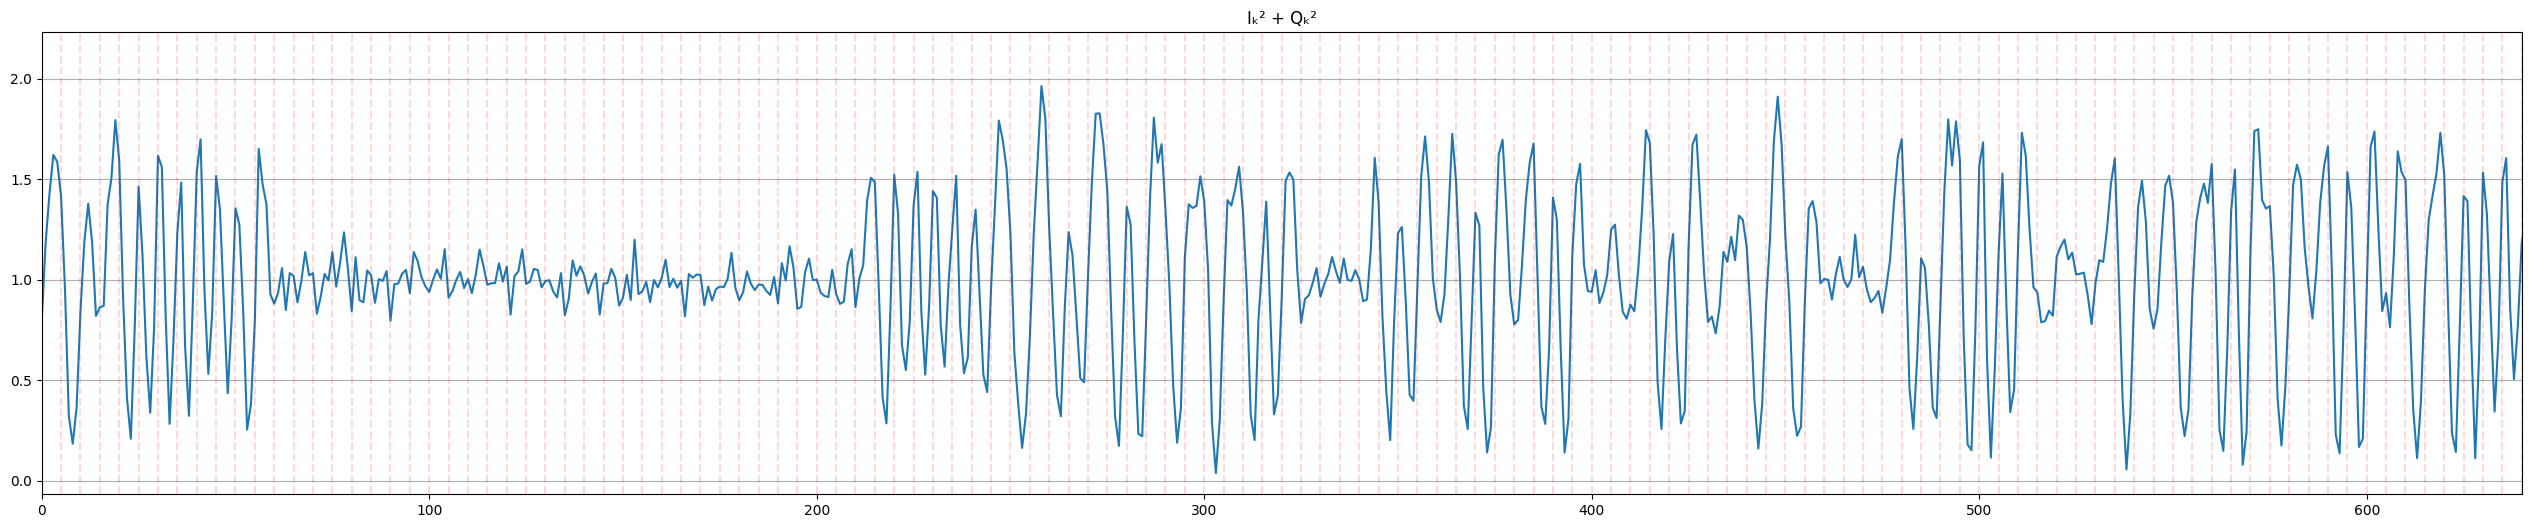

In [19]:
# Calculate the instanteneous energy in both channels
energy = np.pow(samples.real, 2) + np.pow(samples.imag, 2)

# Plot a frequency domain representation of the signal
plt.figure()
plt.gcf().set_size_inches(16, 6)
plt.magnitude_spectrum(energy, Fs=samp_rate, scale='dB', color='C0', pad_to=32000)
plt.title("FFT of Baseband Signal Energy")
plt.xlim(0, 30000)

# Mark the symbol rate
plt.axvline(x=(1/sym_sec), color='red', linestyle='--', alpha=0.5, label='Symbol Rate')

# Plot
plt.figure()
plt.grid(axis='y')
plt.plot(energy)

# Draw symbol peaks
for i in enumerate(range(0, len(samples), sym_samples)):

    # Mark the symbol peak
    peak = plt.axvline(x=i[1], color='red', linestyle='--', alpha=0.15, label='Symbol Peak')

# Make the plot horizontally larger
plt.title(f"Iₖ² + Qₖ²")
plt.gcf().set_size_inches(32, 6)
plt.xlim(0, len(samples)/2)

(0.0, 640.0)

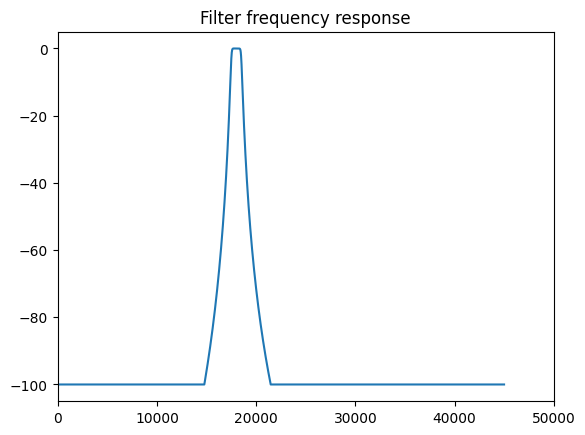

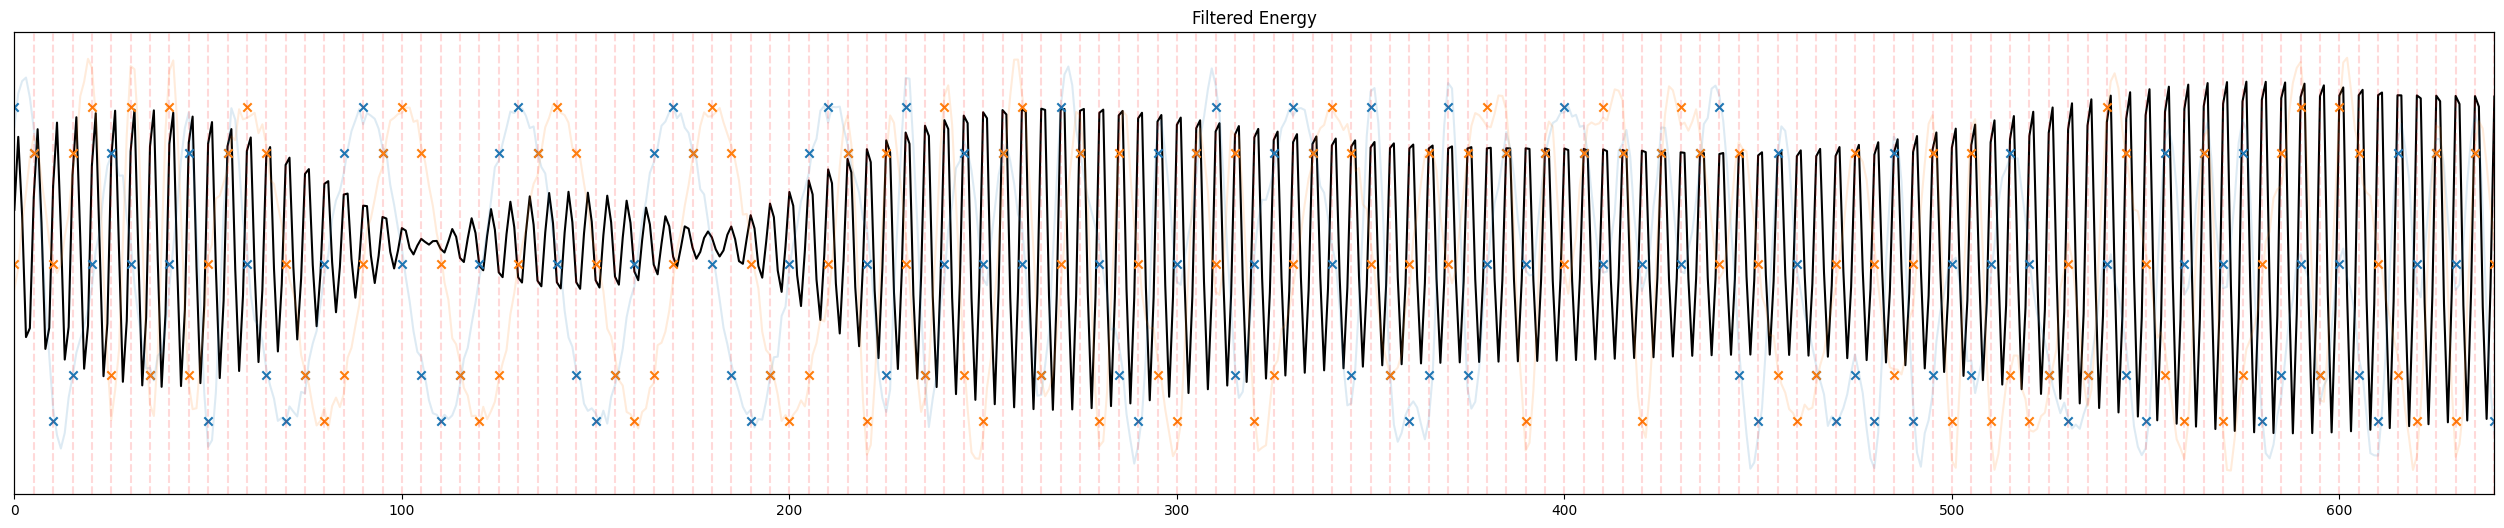

In [20]:
# Now we'll run the energy though a band-pass filter centred at the symbol rate
import scipy.signal

# Define the filter
sym_rate = 18000
band = 500

def bandpass_sos(edges: list[float], sample_rate: float, poles: int = 6):
    return scipy.signal.butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')

def bandpass(data: np.ndarray, edges: list[float], sample_rate: float, poles: int = 6):
    sos = bandpass_sos(edges, sample_rate, poles)
    filtered_data = scipy.signal.sosfiltfilt(sos, data)
    return filtered_data

edges = [sym_rate - band, sym_rate + band]

# Generate the filter
sos = bandpass_sos(edges, samp_rate)

# Plot the filter response
w, h = scipy.signal.sosfreqz(sos, worN=8000, fs=samp_rate)
plt.figure()
plt.plot(w, 20 * np.log10(np.maximum(abs(h), 1e-5)))
plt.title('Filter frequency response')

# Zoom to show 0-50kHz
plt.xlim(0, 50000)

# Apply the filter
filtered_energy = bandpass(energy, edges, samp_rate)

# Plot the filtered energy
plt.figure()
plt.plot(filtered_energy, color='black')
plt.title('Filtered Energy')
plt.gcf().set_size_inches(16, 6)

# Hide y axis ticks
plt.yticks([])

# Alternate axis
plt.twinx()
plt.grid()

# Overplot the I/Q data
plt.plot(samples.real, color='C0', alpha=0.15)
plt.plot(samples.imag, color='C1', alpha=0.15)

# Plot the symbol peaks
for i in enumerate(range(0, len(samples), sym_samples)):
    peak = plt.axvline(x=i[1], color='red', linestyle='--', alpha=0.15, label='Symbol Peak')

    # Also plot this symbol
    plt.scatter([i[1]], [symbols.real[i[0]]], color='C0', marker='x')
    plt.scatter([i[1]], [symbols.imag[i[0]]], color='C1', marker='x')

# Hide y axis ticks
plt.yticks([])

# Zoom
plt.gcf().set_size_inches(32, 6)
plt.xlim(0, len(samples)/2)